# Analisando dados de espécies de fauna em perigo de extinção no Brasil
#### Por Fernando Sanjar Mazzilli, em Agosto de 2021

## Sumário
1. **[Introdução](#intro)**
2. **[Criando a Base de Dados](#etapa1)**
    1. [Diagrama Inicial](#diagrama1)
3. **[Visualizando e filtrando dados com SQL](#etapa2)**
    1. [Consulta para visualizar todas as espécies em risco em diferentes Unidades de Conservação ](#e2.1)
    2.  [Usando a claúsula WHERE para filtrar resultados](#e2.2)
    3.  [Usando expressões regulares no SQL (REGEX) para filtrar por Estado(s)](#e2.3)
4. **[Refinando Dados](#etapa3)**
    1. [Importando novos dados da Internet](#e3.1)
    2. [Detalhando variáveis já existentes](#e3.2)
    3. [Diagrama Completo](#e3.3)
5. **[Contabilizando dados e cruzando informações](#etapa4)**
    1. [Número de espécies ameaçadas por Unidade Federal (UF) e categoria de risco](#e4.1)
    2. [Número de espécies ameaçadas por índices de IDH e Alfabetização](#e4.2)
    3. [Número de espécies ameaçadas por Classe e Divisão](#e4.3)
6. **[6. Visualizações e gráficos](#etapa5)**
    1. [Total de Espécies Ameaçadas por UF e Grau de Risco](#e5.1)
    2. [Dispersão entre Número de Espécies em Risco e IDH ou Alfabetização](#e5.2)
    3. [Total de espécies ameaçadas por Divisão e Grau de Risco](#e5.3)
7. **[Bibliografia](#biblio)**


<a name="intro"></a>
## 1. Introdução
#### Este caderno é um experimento para importar e tratar dados armazenados em uma planilha do Microsoft Excel que contém informações sobre as espécies de fauna em risco de extinção nas principiais áreas de preservação e parques nacionais brasileiros.

Os dados utilizados foram obtidos no [Portal Brasileiro de Dados Abertos](https://dados.gov.br/), e são de autoria da CNCFlora (2016). Consulte a bibliografia para acessá-los.
<br><br>
Neste caderno, meu objetivo primário foi limpar e organizar os dados armazenados na planilha excel, que contém muitas strings repetidas em todas as colunas. Desta maneira, foi possível **reduzir o tamanho do conjunto de dados em cerca de 90%**. <br><br>
Para isso, utilizei o framework **Pandas** para importar os dados da planilha excel e manipulá-los utilizado a linguagem Python. Em seguida, armazenei todas as informações limpas em uma **base de dados SQLite**. Acredito que existam passos desnecessários e maneiras mais eficientes de tratar os dados utilizando apenas o Pandas, então feedbacks são muito bem-vindos! Vale lembrar que este é um **projeto de aprendizado**, e entendi que era mais interessante testar vários recursos diferentes.
<br><br>
Uma vez com os dados da fonte primária limpos e armazenados na base de dados, criei algumas visualizações simples usando **filtros, limitadores e expressões regulares no SQL**. Aproveitei para inserir dados adicionais na base a partir de informações extraídas diretamente da internet, utilizando o método _read_html_ da biblioteca Pandas

Por fim, fiz algumas análises simples de distribuição de espécies de fauna ameaçadas de extinção por grau de risco, Estado e Unidade de Preservação. Criei **visualizações e gráficos** utilizando as bibliotecas (inserir bibliotecas)


<a name="etapa1"></a>
## 2. Criando a Base de Dados
#### Carregando dependencias, fonte de dados e dataframe do Pandas

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as db
from IPython.display import display #para visualizar dados
src = input("Insira o nome da planilha, ou tecle Enter para usar o nome padrão: ")
if len(src) < 1:
    src = "fauna_fed.xlsx"
data = pd.read_excel(src)
print("Dados carregados como: " + str(type(data)))
display(data)

Insira o nome da planilha, ou tecle Enter para usar o nome padrão: 
Dados carregados como: <class 'pandas.core.frame.DataFrame'>


,Número identificador do táxon,Divisão em: Invertebrados ou Vertebrados,Número da Portaria vigente (Portarias MMA 444/2014 e 445/2014),"Divisão em: Anfíbios, Aves, Invertebrados Aquáticos, Invertebrados Terrestres, Mamíferos, Peixes Continentais, Peixes Marinhos ou Répteis",Classe segundo classificação taxonômica,Ordem segundo classificação taxonômica,Família segundo classificação taxonômica,Táxon ao qual as informações dos demais campos se refere. De acordo com nomes do Livro Vermelho 2018,Táxon ao qual as informações dos demais campos se refere. De acordo com as portarias MMA 444/2014 e 445/2014,Categoria do estado de conservação do táxon validada na oficina de validação,Unidade de conservação de ocorrência da espécie,Unnamed: 11,Código CNUC da UC de ocorrência da espécie,Estado sobre ocorrência em UC da espécie,Unnamed: 14,Unnamed: 15
0,8458,Vertebrados,444/2014,Anfíbios,Amphibia,Anura,Leptodactylidae,NaN,Physalaemus maximus,VU,APA de Araponga,MG,?,Presença em UC,NaN,Livro Vermelho 2018
1,11070,Vertebrados,444/2014,Mamíferos,Mammalia,Cingulata,Dasypodidae,NaN,Priodontes maximus,VU,PE Serra de Santa Bárbara,MT,0000.51.0462,Presença em UC,NaN,Livro Vermelho 2018
2,11132,Vertebrados,444/2014,Mamíferos,Mammalia,Perissodactyla,Tapiriidae,NaN,Tapirus terrestris,VU,PE Serra de Santa Bárbara,MT,0000.51.0462,Presença em UC,NaN,Livro Vermelho 2018
3,10802,Vertebrados,444/2014,Mamíferos,Mammalia,Artiodacyla,Tayassuidae,NaN,Tayassu pecari,VU,PE Serra de Santa Bárbara,MT,0000.51.0462,Presença em UC,NaN,Livro Vermelho 2018
4,2355,Invertebrados,445/2014,Invertebrados Aquáticos,Malacostraca,Decapoda,Aeglidae,NaN,Aegla brevipalma,CR,* Desconhecida,-,-,Desconhecido,NaN,Livro Vermelho 2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5223,10978,Vertebrados,444/2014,Mamíferos,Mammalia,Chiroptera,Phyllostomidae,NaN,Lonchorhina aurita,VU,RPPN Vila Amanda,MG,0000.00.1286,Presença em UC,NaN,Livro Vermelho 2018
5224,10594,Vertebrados,444/2014,Aves,Aves,Tinamiformes,Tinamidae,NaN,Crypturellus noctivagus noctivagus,VU,RPPN Volta Velha,SC,?,Presença em UC,NaN,Livro Vermelho 2018
5225,10341,Vertebrados,444/2014,Aves,Aves,Piciformes,Picidae,Dryocopus galeatus,Celeus galeatus,EN,RPPN Volta Velha,SC,?,Presença em UC,NaN,Livro Vermelho 2018
5226,9619,Vertebrados,444/2014,Aves,Aves,Passeriformes,Rhynchocyclidae,NaN,Hemitriccus kaempferi,VU,RPPN Volta Velha,SC,?,Presença em UC,NaN,Livro Vermelho 2018


#### Há muitas strings repetidas; vamos transformá-las em chaves primárias em tabelas específicas, para que possamos utilizá-las como chaves estrangeiras em outras tabelas:

In [2]:
def criar_CP (fonte, nome_coluna, lista): #onde fonte é um dataframe Pandas e lista é uma variável onde serão armazenados os dicionários criados
    kp = dict()
    chave = 0
    for item in fonte[nome_coluna]:
        if item in kp:
            continue
        kp[item] = chave
        chave += 1 
    lista.append(kp)
    print("Chaves criadas para elementos da coluna: " + nome_coluna)

tabelas = list()
for col in data.columns[3:7]: # tabelas CP de divisão até família
    criar_CP(data, col, tabelas)
for col in data.columns[8:12]: # tabelas CP de espécies até Unidades Federais
    criar_CP(data, col, tabelas)
    
#obs: Poderíamos ter atingido um resultado semelhante utilizando o méotodo pd.core.frame.DataFrame.unique para cada uma das 
#     colunas, que retorna uma lista dos elementos únicos em uma coluna. A partir disso, poderíamos pedir para que o SQL 
#     criasse as chaves primárias automaticamente  para cada entrada adicionada na base de dados, bastando 
#     adicionar o argumento AUTOINCREMENT para as colunas "id" nas claúsulas CREATE escritas abaixo

Chaves criadas para elementos da coluna: Divisão em: Anfíbios, Aves, Invertebrados Aquáticos, Invertebrados Terrestres, Mamíferos, Peixes Continentais, Peixes Marinhos ou Répteis
Chaves criadas para elementos da coluna: Classe segundo classificação taxonômica
Chaves criadas para elementos da coluna: Ordem segundo classificação taxonômica
Chaves criadas para elementos da coluna: Família segundo classificação taxonômica
Chaves criadas para elementos da coluna: Táxon ao qual as informações dos demais campos se refere. De acordo com as portarias MMA 444/2014 e 445/2014
Chaves criadas para elementos da coluna: Categoria do estado de conservação do táxon validada na oficina de validação
Chaves criadas para elementos da coluna: Unidade de conservação de ocorrência da espécie
Chaves criadas para elementos da coluna: Unnamed: 11


#### Criando base de dados SQLite e inserindo chaves primárias

In [3]:
db.register_adapter(np.int32, int)  #Necessário para que o SQLite aceite ints com mais de 8 bits, 
db.register_adapter(np.int64, int)  #como é o caso das ints geradas pelo pandas

conn = db.connect("fauna_db.sqlite")
cur = conn.cursor()

cur.executescript("""
DROP TABLE IF EXISTS especie;
DROP TABLE IF EXISTS categoria;
DROP TABLE IF EXISTS divisao;
DROP TABLE IF EXISTS classe;
DROP TABLE IF EXISTS ordem;
DROP TABLE IF EXISTS familia;
DROP TABLE IF EXISTS UC;
DROP TABLE IF EXISTS UF;
DROP TABLE IF EXISTS risco;

CREATE TABLE risco (
    especie_id INTEGER,
    categoria_id INTEGER,
    UC_id INTEGER
);

CREATE TABLE especie (
    id  INTEGER NOT NULL PRIMARY KEY UNIQUE,
    nome    TEXT UNIQUE,    
    divisao_id INTEGER,
    classe_id INTEGER,
    familia_id INTEGER,
    ordem_id INTEGER
);

CREATE TABLE categoria (
    id  INTEGER NOT NULL PRIMARY KEY UNIQUE,
    nome    TEXT UNIQUE
);

CREATE TABLE divisao (
    id  INTEGER NOT NULL PRIMARY KEY UNIQUE,
    nome    TEXT UNIQUE
);

CREATE TABLE classe (
    id  INTEGER NOT NULL PRIMARY KEY UNIQUE,
    nome    TEXT UNIQUE
);

CREATE TABLE ordem (
    id  INTEGER NOT NULL PRIMARY KEY UNIQUE,
    nome    TEXT UNIQUE,
    classe_id INTEGER
);
CREATE TABLE familia (
    id  INTEGER NOT NULL PRIMARY KEY UNIQUE,
    nome    TEXT UNIQUE,
    ordem_id INTEGER
);
CREATE TABLE UC (
    id  INTEGER NOT NULL PRIMARY KEY UNIQUE,
    nome    TEXT UNIQUE,
    UF_id INTEGER
);
CREATE TABLE UF (
    id  INTEGER NOT NULL PRIMARY KEY UNIQUE,
    nome    TEXT UNIQUE
);

                 """)

titulos = ["divisao", "classe", "ordem", "familia", "especie", "categoria", "UC", "UF"]
i = 0
for tabela in tabelas:
    for nome in tabela:
        cur.execute("INSERT OR IGNORE INTO " +titulos[i] + " (id, nome) VALUES (?, ?)", (tabela[nome], nome, ))
    conn.commit()
    print("Chaves primárias inseridas na tabela \"" + titulos[i] + "\" do banco de dados")
    i += 1
    

Chaves primárias inseridas na tabela "divisao" do banco de dados
Chaves primárias inseridas na tabela "classe" do banco de dados
Chaves primárias inseridas na tabela "ordem" do banco de dados
Chaves primárias inseridas na tabela "familia" do banco de dados
Chaves primárias inseridas na tabela "especie" do banco de dados
Chaves primárias inseridas na tabela "categoria" do banco de dados
Chaves primárias inseridas na tabela "UC" do banco de dados
Chaves primárias inseridas na tabela "UF" do banco de dados


<a name="diagrama1"></a>
###  2.1 Diagrama Inicial
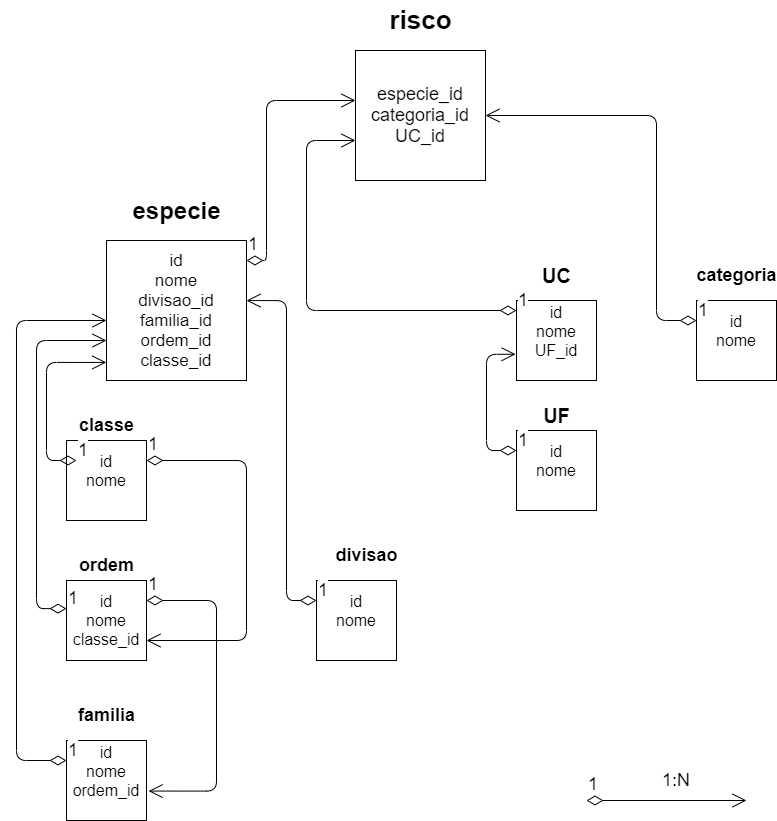
<br>
(Diagrama elaborado em: https://app.diagrams.net/)

#### Mapeando chaves estrangeiras no dataframe pandas

In [4]:
headers = list()
for col in data.columns[3:7]:
    headers.append(col)
for col in data.columns[8:12]:
    headers.append(col)
for i in range (len(tabelas)):  
    print ("Mapendo chaves estrangeiras na coluna:", headers[i])
    data[headers[i]] = data[headers[i]].map(tabelas[i]) #substitui todos os valores por suas respectivas chaves no dataset com base no dicionário presente em tabelas
display(data)

Mapendo chaves estrangeiras na coluna: Divisão em: Anfíbios, Aves, Invertebrados Aquáticos, Invertebrados Terrestres, Mamíferos, Peixes Continentais, Peixes Marinhos ou Répteis
Mapendo chaves estrangeiras na coluna: Classe segundo classificação taxonômica
Mapendo chaves estrangeiras na coluna: Ordem segundo classificação taxonômica
Mapendo chaves estrangeiras na coluna: Família segundo classificação taxonômica
Mapendo chaves estrangeiras na coluna: Táxon ao qual as informações dos demais campos se refere. De acordo com as portarias MMA 444/2014 e 445/2014
Mapendo chaves estrangeiras na coluna: Categoria do estado de conservação do táxon validada na oficina de validação
Mapendo chaves estrangeiras na coluna: Unidade de conservação de ocorrência da espécie
Mapendo chaves estrangeiras na coluna: Unnamed: 11


,Número identificador do táxon,Divisão em: Invertebrados ou Vertebrados,Número da Portaria vigente (Portarias MMA 444/2014 e 445/2014),"Divisão em: Anfíbios, Aves, Invertebrados Aquáticos, Invertebrados Terrestres, Mamíferos, Peixes Continentais, Peixes Marinhos ou Répteis",Classe segundo classificação taxonômica,Ordem segundo classificação taxonômica,Família segundo classificação taxonômica,Táxon ao qual as informações dos demais campos se refere. De acordo com nomes do Livro Vermelho 2018,Táxon ao qual as informações dos demais campos se refere. De acordo com as portarias MMA 444/2014 e 445/2014,Categoria do estado de conservação do táxon validada na oficina de validação,Unidade de conservação de ocorrência da espécie,Unnamed: 11,Código CNUC da UC de ocorrência da espécie,Estado sobre ocorrência em UC da espécie,Unnamed: 14,Unnamed: 15
0,8458,Vertebrados,444/2014,0,0,0,0,NaN,0,0,0,0,?,Presença em UC,NaN,Livro Vermelho 2018
1,11070,Vertebrados,444/2014,1,1,1,1,NaN,1,0,1,1,0000.51.0462,Presença em UC,NaN,Livro Vermelho 2018
2,11132,Vertebrados,444/2014,1,1,2,2,NaN,2,0,1,1,0000.51.0462,Presença em UC,NaN,Livro Vermelho 2018
3,10802,Vertebrados,444/2014,1,1,3,3,NaN,3,0,1,1,0000.51.0462,Presença em UC,NaN,Livro Vermelho 2018
4,2355,Invertebrados,445/2014,2,2,4,4,NaN,4,1,2,2,-,Desconhecido,NaN,Livro Vermelho 2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5223,10978,Vertebrados,444/2014,1,1,61,126,NaN,539,0,986,0,0000.00.1286,Presença em UC,NaN,Livro Vermelho 2018
5224,10594,Vertebrados,444/2014,7,15,72,150,NaN,478,0,987,5,?,Presença em UC,NaN,Livro Vermelho 2018
5225,10341,Vertebrados,444/2014,7,15,42,73,Dryocopus galeatus,740,2,987,5,?,Presença em UC,NaN,Livro Vermelho 2018
5226,9619,Vertebrados,444/2014,7,15,44,178,NaN,722,0,987,5,?,Presença em UC,NaN,Livro Vermelho 2018


#### Populando tabelas *risco*, *especie*, *familia* e *ordem* da base de dados:

In [5]:
for i in range(len(data)):
    divisao_id = data[data.columns[3]][i]
    classe_id = data[data.columns[4]][i]
    ordem_id = data[data.columns[5]][i]
    familia_id = data[data.columns[6]][i]    
    especie_id = data[data.columns[8]][i]
    categoria_id = data[data.columns[9]][i]
    UC_id = data[data.columns[10]][i]
    UF_id = data[data.columns[11]][i]        
    cur.execute("""INSERT INTO risco (especie_id, categoria_id, UC_id) VALUES (?, ?, ?)""", (especie_id, categoria_id, UC_id, ))    
    cur.execute("""UPDATE especie SET divisao_id = ?, classe_id = ?, ordem_id = ?, familia_id= ? WHERE id = ? """, (divisao_id, classe_id, ordem_id, familia_id, especie_id,))
    cur.execute("""UPDATE familia SET ordem_id = ? WHERE id = ? """, (ordem_id, familia_id, ))
    cur.execute("""UPDATE ordem SET classe_id = ? WHERE id = ? """, (classe_id, ordem_id, ))  
    cur.execute("""UPDATE UC SET UF_id = ? WHERE id = ?""", (UF_id, UC_id, ))
conn.commit()
print("Tabelas populadas")



Tabelas populadas


<a name="etapa2"></a>
## 3. Visualizando e filtrando dados com SQL
#### Carregando módulos para rodar consultas SQL no JupyterNotebooks e conectando base de dados

In [6]:
%load_ext sql
%sql sqlite:///fauna_db.sqlite

<a name="e2.1"></a>
### 3.1 Consulta (_querry_) para visualizar todas as espécies em risco em diferentes Unidades de Conservação :
#### (30 primeiros resultados, organizados de forma descrescente em relação ao nome da classe)

In [7]:
%%sql

SELECT especie.nome as "Espécie", divisao.nome as "Divisão", classe.nome as "Classe", ordem.nome as "Ordem", familia.nome as "Família", categoria.nome as "Risco de Extinção", UC.nome as "Unidade de Conservação", UF.nome as "Estado(s)"  
FROM risco JOIN especie JOIN divisao JOIN classe JOIN ordem JOIN familia JOIN categoria JOIN UC JOIN UF
WHERE risco.especie_id = especie.id AND risco.categoria_id = categoria.id AND risco.UC_id = UC.id AND especie.divisao_id = divisao.id AND especie.familia_id = familia.id AND especie.classe_id = classe.id AND especie.ordem_id = ordem.id AND UC.UF_id = UF.id
ORDER BY classe.nome DESC
LIMIT 30


 * sqlite:///fauna_db.sqlite
Done.


Espécie,Divisão,Classe,Ordem,Família,Risco de Extinção,Unidade de Conservação,Estado(s)
Bouchardia rosea,Invertebrados Aquáticos,Rhynchonellata,Terebratulida,Bouchardiidae,EN,* Desconhecida,-
Ameiva parecis,Répteis,Reptilia,Squamata,Teiidae,EN,* Desconhecida,-
Amphisbaena uroxena,Répteis,Reptilia,Squamata,Amphisbanidae,EN,* Desconhecida,-
Apostolepis quirogai,Répteis,Reptilia,Squamata,Dipsadidae,EN,* Desconhecida,-
Apostolepis serrana,Répteis,Reptilia,Squamata,Dipsadidae,EN,* Desconhecida,-
Apostolepis striata,Répteis,Reptilia,Squamata,Dipsadidae,EN,* Desconhecida,-
Atractus hoogmoedi,Répteis,Reptilia,Squamata,Dipsadidae,EN,* Desconhecida,-
Atractus thalesdelemai,Répteis,Reptilia,Squamata,Dipsadidae,EN,* Desconhecida,-
Bachia psamophila,Répteis,Reptilia,Squamata,Gymnophthalmidae,CR,* Desconhecida,-
Brasiliscincus caissara,Répteis,Reptilia,Squamata,Mabuyidae,EN,* Desconhecida,-


<a name="e2.2"></a>
### 3.2 Usando a claúsula WHERE para filtrar resultados
#### Vamos tentar visualizar apenas os anfíbios em risco de extinção:

Para isso, podemos seguir dois caminhos: **filtrar pela chave estrangeira** que chama a string "Amphibia" em nossa consulta, ou então **filtrar pela string** "Amphibia" diretamente.   
Para filtrar pela chave estrangeira, primeiro devemos descobrir qual a **chave primária** associada à classe "Amphibia" na tabela classe:

In [8]:
%%sql

SELECT classe.id, classe.nome from classe WHERE classe.nome = "Amphibia"

 * sqlite:///fauna_db.sqlite
Done.


id,nome
0,Amphibia


Sabendo que a **chave primária** associada à classe Ampibia é **0**, podemos modificar a consulta inicial adicionando o seguinte argumento na cláusula **WHERE**:
>classe.id = 0 

In [9]:
%%sql

SELECT especie.nome as "Espécie", divisao.nome as "Divisão", classe.nome as "Classe", ordem.nome as "Ordem", familia.nome as "Família", 
       categoria.nome as "Risco de Extinção", UC.nome as "Unidade de Conservação", UF.nome as "Estado(s)"  
FROM   risco JOIN especie JOIN divisao JOIN classe JOIN ordem JOIN familia JOIN categoria JOIN UC JOIN UF
WHERE  risco.especie_id = especie.id AND risco.categoria_id = categoria.id AND risco.UC_id = UC.id AND especie.divisao_id = divisao.id
       AND especie.familia_id = familia.id AND especie.classe_id = classe.id AND especie.ordem_id = ordem.id AND UC.UF_id = UF.id 
       AND classe.id = 0

 * sqlite:///fauna_db.sqlite
Done.


Espécie,Divisão,Classe,Ordem,Família,Risco de Extinção,Unidade de Conservação,Estado(s)
Physalaemus maximus,Anfíbios,Amphibia,Anura,Leptodactylidae,VU,APA de Araponga,MG
Adelophryne maranguapensis,Anfíbios,Amphibia,Anura,Eleutherodactylidae,VU,* Não,-
Aparasphenodon pomba,Anfíbios,Amphibia,Anura,Hylidae,CR,* Não,-
Bokermannohyla vulcaniae,Anfíbios,Amphibia,Anura,Hylidae,CR,* Não,-
Chiasmocleis alagoanus,Anfíbios,Amphibia,Anura,Microhylidae,EN,* Não,-
Cycloramphus diringshofeni,Anfíbios,Amphibia,Anura,Cycloramphidae,CR,* Não,-
Cycloramphus faustoi,Anfíbios,Amphibia,Anura,Cycloramphidae,CR,* Não,-
Melanophryniscus admirabilis,Anfíbios,Amphibia,Anura,Bufonidae,CR,* Não,-
Melanophryniscus macrogranulosus,Anfíbios,Amphibia,Anura,Bufonidae,EN,* Não,-
Phrynomedusa fimbriata,Anfíbios,Amphibia,Anura,Hylidae,EX,* Não,-


Também podemos utilizar a string diretamente como filtro. Por exemplo: agora, entre os anfíbios, queremos saber apenas os que estão em risco de extinção na categoria CR. Podemos adicionar o seguinte argumento na cláusula **WHERE**:   
> categoria.nome = "CR"


In [10]:
%%sql

SELECT especie.nome as "Espécie", divisao.nome as "Divisão", classe.nome as "Classe", ordem.nome as "Ordem", familia.nome as "Família", 
       categoria.nome as "Risco de Extinção", UC.nome as "Unidade de Conservação", UF.nome as "Estado(s)"  
FROM   risco JOIN especie JOIN divisao JOIN classe JOIN ordem JOIN familia JOIN categoria JOIN UC JOIN UF
WHERE  risco.especie_id = especie.id AND risco.categoria_id = categoria.id AND risco.UC_id = UC.id AND especie.divisao_id = divisao.id
       AND especie.familia_id = familia.id AND especie.classe_id = classe.id AND especie.ordem_id = ordem.id AND UC.UF_id = UF.id 
       AND classe.id = 0 AND categoria.nome = "CR"

 * sqlite:///fauna_db.sqlite
Done.


Espécie,Divisão,Classe,Ordem,Família,Risco de Extinção,Unidade de Conservação,Estado(s)
Aparasphenodon pomba,Anfíbios,Amphibia,Anura,Hylidae,CR,* Não,-
Bokermannohyla vulcaniae,Anfíbios,Amphibia,Anura,Hylidae,CR,* Não,-
Cycloramphus diringshofeni,Anfíbios,Amphibia,Anura,Cycloramphidae,CR,* Não,-
Cycloramphus faustoi,Anfíbios,Amphibia,Anura,Cycloramphidae,CR,* Não,-
Melanophryniscus admirabilis,Anfíbios,Amphibia,Anura,Bufonidae,CR,* Não,-
Proceratophrys palustris,Anfíbios,Amphibia,Anura,Odontophrynidae,CR,* Não,-
Proceratophrys sanctaritae,Anfíbios,Amphibia,Anura,Odontophrynidae,CR,* Não,-
Ololygon alcatraz,Anfíbios,Amphibia,Anura,Hylidae,CR,* Não,-
Allobates brunneus,Anfíbios,Amphibia,Anura,Aromobatidae,CR,APA da Chapada dos Guimarães,MT
Physalaemus soaresi,Anfíbios,Amphibia,Anura,Leptodactylidae,CR,APA de Gericinó-Mendanha,RJ


<a name="e2.3"></a>
###  3.3 Usando expressões regulares no SQL (REGEX) para filtrar por Estado(s)
Na tabela UF, que contém as siglas dos estados brasileiros, há algumas entradas que possuem mais do que uma sigla (como MG/RJ). Isto acontece porque há parques que ocupam vários estados, e, na fonte de dados original, optou-se por incluir todos os estados separados por barras.   
Para que isso não seja um problema no momento de filtrar as espécies em extinção por Estado, podemos utilizar expressões regulares para flexibilizar os filtros.    
Por exemplo: se, para identificar todos os anfíbios em risco de extinção no estado de MG, adicionássemos à clausula **WHERE** 
> UF.nome = "MG"

O SQL ignoraria todas as linhas com MG/RJ, pois a string "MG" que indicamos no filtro é diferente de "MG/RJ". Desta maneira, deixaríamos de recuperar resultados válidos para nosso filtro.   

Para evitar este problema, podemos adicionar como argumento na cláusula **WHERE**:
>UF.nome like "%MG%"

Em REGEX, _**%**_ significa "qualquer string". _**like**_ indica ao SQL que usaremos uma REGEX. Desta maneira, a expressão acima significa "qualquer string seguida por MG seguida por qualquer string". Em outras palavras, basta que a string "MG" esteja contida na string armazenada no banco de dados para que o filtro seja ativado. Vejamos:

In [11]:
%%sql

SELECT especie.nome as "Espécie", divisao.nome as "Divisão", classe.nome as "Classe", ordem.nome as "Ordem", familia.nome as "Família", 
       categoria.nome as "Risco de Extinção", UC.nome as "Unidade de Conservação", UF.nome as "Estado(s)"  
FROM   risco JOIN especie JOIN divisao JOIN classe JOIN ordem JOIN familia JOIN categoria JOIN UC JOIN UF
WHERE  risco.especie_id = especie.id AND risco.categoria_id = categoria.id AND risco.UC_id = UC.id AND especie.divisao_id = divisao.id
       AND especie.familia_id = familia.id AND especie.classe_id = classe.id AND especie.ordem_id = ordem.id AND UC.UF_id = UF.id 
       AND classe.id = 0 AND UF.nome like "%MG%"

 * sqlite:///fauna_db.sqlite
Done.


Espécie,Divisão,Classe,Ordem,Família,Risco de Extinção,Unidade de Conservação,Estado(s)
Physalaemus maximus,Anfíbios,Amphibia,Anura,Leptodactylidae,VU,APA de Araponga,MG
Holoaden luederwaldti,Anfíbios,Amphibia,Anura,Craugastoridae,EN,APA Serra da Mantiqueira,MG/RJ/SP
Physalaemus maximus,Anfíbios,Amphibia,Anura,Leptodactylidae,VU,MN Estadual de Itatiaia,MG
Holoaden bradei,Anfíbios,Amphibia,Anura,Craugastoridae,CR,PARNA do Itatiaia,MG/RJ
Holoaden luederwaldti,Anfíbios,Amphibia,Anura,Craugastoridae,EN,PARNA do Itatiaia,MG/RJ
Paratelmatobius lutzii,Anfíbios,Amphibia,Anura,Leptodactylidae,CR,PARNA do Itatiaia,MG/RJ
Scinax duartei,Anfíbios,Amphibia,Anura,Hylidae,VU,PARNA do Itatiaia,MG/RJ
Physalaemus maximus,Anfíbios,Amphibia,Anura,Leptodactylidae,VU,PE Serra do Brigadeiro,MG


<a name="etapa3"></a>
## 4. Refinando Dados

Nesta seção, vamos utilizar os dados armazenados em nossa base de dados para realizar análises, cruzando informações que temos em diferentes tabelas. Não precisamos, contudo, nos restringir aos dados presentes em nossa fonte original, como veremos a seguir:

<a name="e3.1"></a>
### 4.1 Importando novos dados da Internet
Antes de fazer análises, vamos garantir que todas as Unidades Federais possuem uma chave primária na tabela UF. Importaremos uma [tabela da Wikipedia](https://pt.wikipedia.org/wiki/Unidades_federativas_do_Brasil) que contém todas as siglas dos Estados utilizando o método _read_html_ do framework Pandas e indicando o filtro "Abreviação" para limitar os resultados

In [12]:
wikitables = pd.read_html("https://pt.wikipedia.org/wiki/Unidades_federativas_do_Brasil", match = "Abreviação") # Retorna uma LISTA de dataframes Pandas
print(len(wikitables), "tabela(s) econtrada(s)")
wikitable = wikitables[0]
print("Tabela carregada na memória como", str(type(wikitable)))
display(wikitable)

1 tabela(s) econtrada(s)
Tabela carregada na memória como <class 'pandas.core.frame.DataFrame'>


,Bandeira,Unidade federativa,Abreviação,Sede de governo,Área (km²),População (2014),Densidade (2005),PIB (2015),(% total) (2015),PIB per capita (R$) (2015),IDH (2010),Alfabetização (2016),Mortalidade infantil (2016),Expectativa de vida (2016)
0,NaN,Acre,AC,Rio Branco,"164 122,2",795 145,430,13 622 000,2,"16 953,46",663,"86,9%","17,0‰","73,9 anos"
1,NaN,Alagoas,AL,Maceió,"27 767,7",3 327 551,10861,46 364 000,8,"13 877,53",631,"80,6%","19,5‰","71,6 anos"
2,NaN,Amapá,AP,Macapá,"142 814,6",756 500,416,13 861 000,2,"18 079,54",708,95%,"23,2‰","73,9 anos"
3,NaN,Amazonas,AM,Manaus,"1 570 745,7",3 893 763,205,86 560 000,14,"21 978,95",674,"93,1%","18,2‰","71,9 anos"
4,NaN,Bahia,BA,Salvador,"564 692,7",15 150 143,2446,245 025 000,41,"16 115,89",660,87%,"17,3‰","73,5 anos"
5,NaN,Ceará,CE,Fortaleza,"148 825,6",8 867 448,5440,130 621 000,22,"14 669,14",682,"84,8%","14,4‰","73,8 anos"
6,NaN,Distrito Federal,DF,Brasília,"5 822,1",2 867 869,40073,215 613 000,36,"73 971,05",824,"97,4%","10,5‰","78,1 anos"
7,NaN,Espírito Santo,ES,Vitória,"46 077,5",3 894 899,7397,120 363 000,2,"30 627,45",740,"93,8%","8,8‰","78,2 anos"
8,NaN,Goiás,GO,Goiânia,"340 086,7",6 551 322,1652,173 632 000,29,"26 265,32",735,"93,5%","14,9‰","74,2 anos"
9,NaN,Maranhão,MA,São Luís,"331 983,3",6 861 924,1838,78 475 000,13,"11 366,23",639,"83,3%","21,3‰","70,6 anos"


Além das **siglas dos estados**, esta tabela contém outras informações interessantes, como o **nome por extenso** da unidade federativa e informações de **IDH e alfabetização**. Podemos importá-las para nossa base de dados, também! Para isso, vamos **modificar a tabela UF em nosso banco de dados e adicionar 3 novas colunas**: nome_ext, idh e alfabetizacao. <br>
 

In [13]:
cur.executescript("""
ALTER TABLE UF ADD nome_ext TEXT;
ALTER TABLE UF ADD idh FLOAT;
ALTER TABLE UF ADD alfabetizacao FLOAT;
""")
print("Colunas adicionadas na tabela UF")

Colunas adicionadas na tabela UF


Em seguida, vamos transportar os dados do dataframe pandas para Tuples do Python, que serão utlizadas para inserir os dados em nossa base de dados:

In [14]:
newinfo = list()
for i in range (len(wikitable)):
    sigla = wikitable["Abreviação"][i]
    nome_ext = wikitable["Unidade federativa"][i]
    idh = wikitable["IDH (2010)"][i]
    alfab = (wikitable["Alfabetização (2016)"][i]).replace(",", ".")
    info = (sigla, nome_ext, idh, alfab)
    newinfo.append(info)   
print ("Extraídas as seguintes informações da tabela:\n", newinfo)

Extraídas as seguintes informações da tabela:
 [('AC', 'Acre', 663, '86.9%'), ('AL', 'Alagoas', 631, '80.6%'), ('AP', 'Amapá', 708, '95%'), ('AM', 'Amazonas', 674, '93.1%'), ('BA', 'Bahia', 660, '87%'), ('CE', 'Ceará', 682, '84.8%'), ('DF', 'Distrito Federal', 824, '97.4%'), ('ES', 'Espírito Santo', 740, '93.8%'), ('GO', 'Goiás', 735, '93.5%'), ('MA', 'Maranhão', 639, '83.3%'), ('MT', 'Mato Grosso', 725, '93.5%'), ('MS', 'Mato Grosso do Sul', 729, '93.7%'), ('MG', 'Minas Gerais', 731, '93.8%'), ('PA', 'Pará', 646, '90.7%'), ('PB', 'Paraíba', 658, '83.7%'), ('PR', 'Paraná', 749, '95.5%'), ('PE', 'Pernambuco', 673, '87.2%'), ('PI', 'Piauí', 646, '82.8%'), ('RJ', 'Rio de Janeiro', 761, '97.3%'), ('RN', 'Rio Grande do Norte', 684, '85.3%'), ('RS', 'Rio Grande do Sul', 746, '96.8%'), ('RO', 'Rondônia', 690, '93.3%'), ('RR', 'Roraima', 707, '93.4%'), ('SC', 'Santa Catarina', 774, '97.2%'), ('SP', 'São Paulo', 783, '97.2%'), ('SE', 'Sergipe', 665, '85.3%'), ('TO', 'Tocantins', 699, '89.6%')]


Agora, podemos iterar pela lista de tuples (**newinfo**) para verificar quais siglas já estão na nossa base de dados, e adicionar aquelas que não estiverem:

In [15]:
for i in range(len(newinfo)):
    cur.execute("""SELECT nome FROM UF WHERE nome = ? """, (newinfo[i][0], ))
    check = cur.fetchone()[0]
    sigla = newinfo[i][0]
    nome_ext = newinfo[i][1]
    idh = float(newinfo[i][2])/1000
    alfab = float(newinfo[i][3][:-1])    
    if check is None:        
        cur.execute("""INSERT INTO UF (nome, nome_ext, idh, alfabetizacao) VALUES (?, ?, ?, ?)""", (sigla, nome_ext, idh, alfab, ))
        print("Sigla \"" + newinfo[i][0] + "\" não estava presente e foi adicionada à base junto com as demais informações")       
    else:
        cur.execute("""UPDATE UF SET nome_ext = ?, idh = ?, alfabetizacao = ? WHERE nome = ?""", (nome_ext, idh, alfab, sigla,))
        print(sigla, nome_ext, idh, alfab, end = " | ")
print("\n")        
conn.commit()

AC Acre 0.663 86.9 | AL Alagoas 0.631 80.6 | AP Amapá 0.708 95.0 | AM Amazonas 0.674 93.1 | BA Bahia 0.66 87.0 | CE Ceará 0.682 84.8 | DF Distrito Federal 0.824 97.4 | ES Espírito Santo 0.74 93.8 | GO Goiás 0.735 93.5 | MA Maranhão 0.639 83.3 | MT Mato Grosso 0.725 93.5 | MS Mato Grosso do Sul 0.729 93.7 | MG Minas Gerais 0.731 93.8 | PA Pará 0.646 90.7 | PB Paraíba 0.658 83.7 | PR Paraná 0.749 95.5 | PE Pernambuco 0.673 87.2 | PI Piauí 0.646 82.8 | RJ Rio de Janeiro 0.761 97.3 | RN Rio Grande do Norte 0.684 85.3 | RS Rio Grande do Sul 0.746 96.8 | RO Rondônia 0.69 93.3 | RR Roraima 0.707 93.4 | SC Santa Catarina 0.774 97.2 | SP São Paulo 0.783 97.2 | SE Sergipe 0.665 85.3 | TO Tocantins 0.699 89.6 | 



<a name="e3.2"></a>
### 4.2 Detalhando variáveis já existentes

Já que estamos adicionando informações em nossa base, vamos aproveitar para **adicionar uma descrição para as siglas na tabela categoria**, que correspondem à intensidade do risco de extinção sob o qual está uma determinada espécie. Do [**Livro Vermelho (P.33, Vol. 1)**](https://www.icmbio.gov.br/portal/images/stories/biodiversidade/fauna-brasileira/livro-vermelho/volumeI/vol_I_parte1.pdf), temos que:  
RE: Regionalmente Extinta|
PEX: Provavelmente Extinta| 
EX: Extinta|
EW: Extinta na Natureza|
CR: Criticamente em Perigo|
EN: Em Perigo|
VU: Vulnerável|
DD: Deficiente em Dados 

In [16]:
cur.executescript("""
ALTER TABLE categoria ADD descricao TEXT;
UPDATE categoria SET descricao = "Vulnerável" WHERE nome = "VU";
UPDATE categoria SET descricao = "Criticamente em Perigo" WHERE nome = "CR";
UPDATE categoria SET descricao = "Em Perigo" where nome = "EN";
UPDATE categoria SET descricao = "Provavelmente Extinta" WHERE nome = "CR(PEX)";
UPDATE categoria SET descricao = "Regionalmente Extinta" WHERE nome = "RE";
UPDATE categoria SET descricao = "Extinta" WHERE nome = "EX";
UPDATE categoria SET descricao = "Provavelmente Extinta na Natureza" WHERE nome = "CR(PEW)";
UPDATE categoria SET descricao = "Extinta na Natureza" WHERE nome = "EW";
""")
print("Coluna adicionada na tabela UC com valores atualizados")

Coluna adicionada na tabela UC com valores atualizados


Podemos fazer o mesmo para as siglas das Unidades de Conservação, utilizando como referência a mesma página do livro vermelho. Contudo, aqui teremos um pouco mais de trabalho, pois temos de **extrair a sigla das strings armazenadas na coluna "nome"** da tabela UC. Primeiro, vamos criar uma nova tabela primária em nossa base de dados para armazenar os tipos de Unidades de Conservação e populá-la. Aproveitaremos para adicionar o campo tipo_id na tabela UC

In [17]:
cur.executescript("""
ALTER TABLE UC ADD tipo_id INTEGER;
DROP TABLE IF EXISTS tipo_UC;

CREATE TABLE tipo_UC (
    id  INTEGER NOT NULL PRIMARY KEY UNIQUE,
    sigla TEXT UNIQUE,
    nome    TEXT 
);

INSERT INTO tipo_UC (sigla, nome) VALUES ("APA", "Área de Proteção Ambiental");
INSERT INTO tipo_UC (sigla, nome) VALUES ("ARIE", "Área de Relevante Interesse Ecológico");
INSERT INTO tipo_UC (sigla, nome) VALUES ("FLONA", "Floresta Nacional");
INSERT INTO tipo_UC (sigla, nome) VALUES ("FLOE", "Floresta Estadual");
INSERT INTO tipo_UC (sigla, nome) VALUES ("FLOM", "Floresta Municipal");
INSERT INTO tipo_UC (sigla, nome) VALUES ("RESEX", "Reserva Extrativista");
INSERT INTO tipo_UC (sigla, nome) VALUES ("REFA", "Reserva da Fauna");
INSERT INTO tipo_UC (sigla, nome) VALUES ("REDES", "Reserva de Desenvolvimento Sustentável");
INSERT INTO tipo_UC (sigla, nome) VALUES ("RPPN", "Reserva Particular do Patrimônio Natural");
INSERT INTO tipo_UC (sigla, nome) VALUES ("FLOEX", "Floresta Extrativista");
INSERT INTO tipo_UC (sigla, nome) VALUES ("ASPE", "Área de Proteção Integral");
INSERT INTO tipo_UC (sigla, nome) VALUES ("PE", "Parque Estadual");
INSERT INTO tipo_UC (sigla, nome) VALUES ("PM", "Parque Municipal");
INSERT INTO tipo_UC (sigla, nome) VALUES ("PARNA", "Parque Nacional");
INSERT INTO tipo_UC (sigla, nome) VALUES ("FLOREST", "Floresta Estadual");
INSERT INTO tipo_UC (sigla, nome) VALUES ("MN", "Monumento Natural");
INSERT INTO tipo_UC (sigla, nome) VALUES ("REVIS", "Refúgio da Vida Silvestre");
INSERT INTO tipo_UC (sigla, nome) VALUES ("ESEC", "Estação Ecológica");
INSERT INTO tipo_UC (sigla, nome) VALUES ("Parque", "Parque");
INSERT INTO tipo_UC (sigla, nome) VALUES ("RDS", "Reserva de Desenvolvimento Sustentável");
INSERT INTO tipo_UC (sigla, nome) VALUES ("REBIO", "Reserva Biológica");


""")
conn.commit()
print("Feito")

Feito


Agora, vamos iterar por todas as linhas da tabela UC, extrair a sigla da coluna "nome" e utilizá-la para identificar o valor que deve ser adicionado na coluna tipo_id 

In [18]:
import re
cur.execute("""SELECT count(*) FROM UC """) #retorna o número total de linhas na tabela
rows = cur.fetchone()[0]
count = 0
for i in range(rows):
    cur.execute("""SELECT nome FROM UC """)
    nome = cur.fetchall()[i][0]
    sigla = re.findall("([^ ]+?) .+", nome) #procure, sem ser ganancioso (?), uma sequencia de um ou mais caracteres (+) que não sejam espaços em branco ([^ ]) seguidos por um ou mais caracteres quaisquer (.+). Selecione apenas o que estiver entre parênteses
    cur.execute("""SELECT id FROM tipo_UC WHERE sigla = ?""", (sigla[0], ))
    tipo_id = cur.fetchone()
    if tipo_id is None:
        print("Sigla não encontrada na linha", i)
        continue
    tipo = int (tipo_id[0])
    i = int(i)
    cur.execute("""UPDATE UC SET tipo_id = ? WHERE id = ?""", (tipo, i))
    count += 1 
conn.commit()
print (count, "de", rows, "registros foram atualizados")

Sigla não encontrada na linha 2
Sigla não encontrada na linha 3
Sigla não encontrada na linha 4
Sigla não encontrada na linha 209
Sigla não encontrada na linha 210
Sigla não encontrada na linha 452
Sigla não encontrada na linha 741
981 de 988 registros foram atualizados


<a name="e3.3"></a>
### 4.3 Diagrama completo
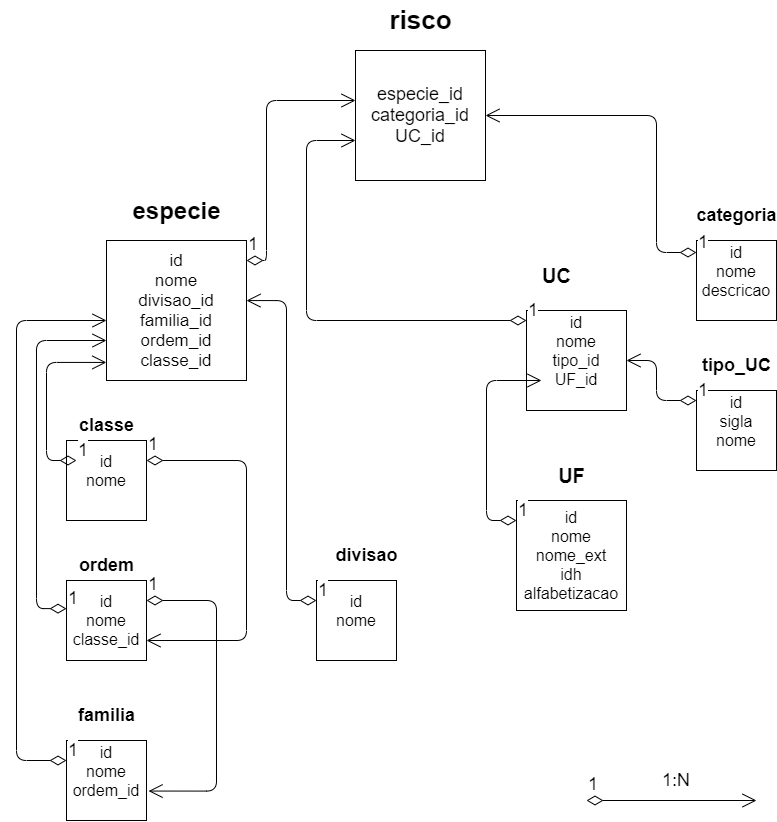

<a name="etapa4"></a>
## 5. Contabilizando dados e cruzando informações

Agora que temos a base de dados completamente populada, podemos realizar consultas filtradas para contabilizar dados e tentar identificar padrões de acordo com as variáveis que temos disponíveis. Seguem algumas possibilidades de análise: 


<a name="e4.1"></a>
### 5.1 Número de espécies ameaçadas por Unidade Federal (UF) e categoria de risco

Vamos criar uma _query_ que retorna o id da espécie, a categoria de risco em que ela está, a descrição desta categoria, a UF em que ela se encontra e o nome por extenso da UF. Considerando estas variáveis, podemos escrever a _query_ aplicando os unindo as seguintes tabelas (com JOIN) e aplicando os seguintes filtros (com WHERE):
>**SELECT** especie.id as "ID", categoria.nome as "Status", categoria.descricao as "Descrição", UF.nome as "UF", >UF.nome_ext as "Estado"       
>**FROM** risco **JOIN** especie **JOIN** categoria **JOIN** UC **JOIN** UF     
>**WHERE** risco.especie_id = especie.id **AND** risco.categoria_id = categoria.id **AND** risco.UC_id = UC.id **AND**  UC.UF_id = UF.id    

Em vez de rodar a _query_ e visualizá-la através da extensão SQL do Jupyter, como fiz na seção 3, vou rodá-la como argumento de uma função da biblioteca Pandas que retorna um dataframe com os resultados da consulta. Assim, teremos todos estes dados prontos para uso dentro do ambiente de programação:

In [62]:
sqlstr = ("""
SELECT especie.id AS "ID", categoria.nome AS "Status", categoria.descricao AS "Descrição", UF.nome AS "UF", UF.nome_ext AS "Estado"  
FROM risco JOIN especie JOIN categoria JOIN UC JOIN UF
WHERE risco.especie_id = especie.id AND risco.categoria_id = categoria.id AND risco.UC_id = UC.id AND  UC.UF_id = UF.id
""")
dados = pd.read_sql_query(sqlstr, conn)
display(dados)

,ID,Status,Descrição,UF,Estado
0,0,VU,Vulnerável,MG,Minas Gerais
1,1,VU,Vulnerável,MT,Mato Grosso
2,2,VU,Vulnerável,MT,Mato Grosso
3,3,VU,Vulnerável,MT,Mato Grosso
4,4,CR,Criticamente em Perigo,-,None
...,...,...,...,...,...
5223,539,VU,Vulnerável,MG,Minas Gerais
5224,478,VU,Vulnerável,SC,Santa Catarina
5225,740,EN,Em Perigo,SC,Santa Catarina
5226,722,VU,Vulnerável,SC,Santa Catarina


Vamos criar uma **estrutura de dados** para armazenar informações numéricas sobre cada UF, contabilizando o Total e também as quantidades espécificas para cada "Status". Para isso, criaremos um dicionário **(count_uf)** que contem como chaves as siglas correspondentes de cada UF, onde armazenaremos como valores outros dicionários, que detalham as informações para cada chave no dicionário primário. Teremos algo do tipo:        
>{          
'MG' : {             
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'Total' : 100,          
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'Vulnerável': 20,      
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'Em perigo': 30,         
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; .....             
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;},       
&nbsp;&nbsp; 'MT' : {           
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'Total' : 70,             
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'Vulnerável': 10,             
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'Em perigo': 20,         
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.....        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; },       

Primeiro, vamos recuperar uma lista das siglas das UF's utilizando o metodo _pandas.core.frame.DataFrame.unique_ e armazená-la na variável **_ufs_**. Também vamos criar um dicionário chamado **_counts_uf_** para armazenar as informações de cada UF.  Em seguida, iniciamos um loop que itera por todo o elemento **_uf_** da lista **_ufs_**.      
Aqui, checamos se o valor de **_uf_** não é nulo, criamos um _subset_ do _DataFrame_ que contém apenas as linhas em que a variável **_uf_** corresponde ao valor armazenado na coluna "UF" do _DataFrame_ e contamos o número de linhas, armazenando o resultado na variável **_count_uf_**. Em seguida, checamos se o valor de **_uf_** é, na verdade, uma string com várias siglas separadas por "/".    
<br>
Se este for o caso, separamos a string em subunidades utilizando o método _split_ e armazenamos as siglas extraídas como uma lista na variável **_split_**.       
<br>
Em seguida, iteramos por todos os elementos da lista **_split_**, verificamos se o elemento (i.e, a sigla) já possui uma chave no dicionário **_counts_uf_** e, caso não tenha, o adicionamos. Feito isso, adicionamos o valor de **_count_uf_** na chave "Total" do dicionário secundário armazenado na chave **_uf_** do dicionário primário (**_counts_uf_**)        
<br>
O passo seguinte é fazer a contagem para cada uma das categorias. Iniciamos um sub-loop que itera por toda **_categoria_** da variável **_categorias_**, uma lista que contém todas as strings únicas usadas na coluna Descrição do _DataFrame_. Criamos um subset do dataframe que satisfaz duas condições: a sigla armazenada em **_split\[i\]_** corresponde à sigla armazenada na coluna "UF" do _DataFrame_, e a string armazenada na variável **_categoria_** corresponde à string armazenada na coluna "Descrição" do _DataFrame_. Realizamos uma contagem das linhas que satisfazem essas condições e a adicionamos à chave correspondente no dicionário secundário.         
<br>
As etapas seguintes são exatamente as mesmas do que as descritas até agora, porém ajustadas para o caso de não haver múltiplas siglas armazenadas na variável **_uf_**

In [63]:
ufs = dados["UF"].unique() #recupera as strings únicas presentes na coluna UF do dataframe dados (i.e, as siglas das UFs)
categorias = dados["Descrição"].unique()
counts_uf = dict()

for uf in ufs:
    
    if uf is None: continue #ignore as linhas sem UF    
    subset_uf = dados["UF"] == uf
    count_uf = dados[subset_uf]["UF"].count()       
    if uf.find("/") != -1: #para os casos em que há várias siglas separadas por "/",  
        split = re.split("/", uf) # dividimos a string 
        for i in range(len(split)): 
            
            if split[i] in counts_uf: #checamos se cada uma das siglas já possui um dicionário equivalente em count_uf
                pass
            else: #adicionamos o dicionário, se não existir
                counts_uf[split[i]] = dict()
                
            counts_uf[split[i]]["Total"] = counts_uf[split[i]].get("Total", 0) + count_uf # adicionamos count_uf à chave "Total" para o dicionário de cada uma das siglas extraídas da string          
            
            for categoria in categorias:
                subset_cat = dados[(dados["Descrição"] == categoria) & (dados["UF"] == uf)] 
                count_cat = subset_cat["Descrição"].count()
                counts_uf[split[i]][categoria] = counts_uf[split[i]].get(categoria, 0) + count_cat
    else:
        
        if uf in counts_uf: #análogo aos últimos comentários
            pass
        else:
            counts_uf[uf] = dict()
            
        counts_uf[uf]["Total"] = counts_uf.get("Total", 0) + count_uf
        
        for categoria in categorias:               
                subset_cat = dados[(dados["Descrição"] == categoria) & (dados["UF"] == uf)]
                count_cat = subset_cat["Descrição"].count()
                if categoria is None: categoria = "Não Informado"
                counts_uf[uf][categoria] = counts_uf[uf].get(categoria, 0) + count_cat

Vamos usar o método _pandas.DataFrame.from_dict_ para transformar este dicionário em um _DataFrame_ pandas e visualizá-lo com o método _display_ que importamos no começo deste caderno

In [64]:
colunas = counts_uf["MG"].keys()
totais_uf = pd.DataFrame.from_dict(counts_uf, orient="index", columns = colunas)
display(totais_uf.sort_values(by = ["Total"], ascending=False))

,Total,Vulnerável,Criticamente em Perigo,Em Perigo,Provavelmente Extinta,Regionalmente Extinta,Extinta,Provavelmente Extinta na Natureza,Extinta na Natureza
SP,617,373,63,175,6,0,0,0,0
BA,578,325,57,196,0,0,0,0,0
RJ,495,273,59,156,7,0,0,0,0
-,446,124,155,141,14,5,5,1,1
MG,415,253,48,112,2,0,0,0,0
PA,371,296,15,60,0,0,0,0,0
PE,314,189,37,88,0,0,0,0,0
PR,256,179,16,57,4,0,0,0,0
AM,253,172,23,58,0,0,0,0,0
ES,246,149,35,59,3,0,0,0,0


<a name="e4.2"></a>
### 5.2 Número de espécies ameaçadas por índices de IDH e Alfabetização
Vamos criar um novo dataframe aproveitando a coluna "Total" do dataframe que criamos na etapa anterior e adicionando as informações de IDH e Alfabetização por UF. Para isso, como na última etapa, utilizamos o método pd.read_sql_querry para extrair as informações pertinentes de nossa base de dados na variável **_dados_**. Em seguida, definimos a coluna "UF" como índice do DataFrame dados usando o método set_index(), e então utilizamos o método pd.concat() para juntar a coluna total ao DataFrame dados, armazenando o resultado na variável idh_uf

In [65]:
sqlstr = ("""
SELECT UF.nome as "UF", UF.idh, uf.alfabetizacao as "Alfabetização" 
FROM UF 
WHERE UF.idh IS NOT NULL AND  UF.alfabetizacao IS NOT NULL
""")
dados = pd.read_sql_query(sqlstr, conn)
dados = dados.set_index("UF")
idh_uf = pd.concat([totais_uf["Total"], dados], axis=1)
display(idh_uf.sort_values(by = ["Alfabetização"], ascending=False))

,Total,idh,Alfabetização
DF,39,0.824,97.4
RJ,495,0.761,97.3
SC,209,0.774,97.2
SP,617,0.783,97.2
RS,157,0.746,96.8
PR,256,0.749,95.5
AP,65,0.708,95.0
MG,415,0.731,93.8
ES,246,0.740,93.8
MS,90,0.729,93.7


<a name="e4.3"></a>
### 5.3 Número de espécies ameaçadas por Classe e Divisão
Aqui, o processo é análogo àquele que seguimos no item 5.1, então não entrarei em detalhes sobre cada procedimento.
#### Totais por Classe

In [68]:
sqlstr = ("""
SELECT especie.nome AS "Nome", categoria.nome AS "Status", categoria.descricao AS "Descrição", classe.nome AS "Classe", divisao.nome AS "Divisão"  
FROM risco JOIN especie JOIN categoria JOIN UC JOIN classe JOIN divisao
WHERE risco.especie_id = especie.id AND risco.categoria_id = categoria.id AND risco.UC_id = UC.id AND  especie.classe_id = classe.id AND especie.divisao_id = divisao.id
""")
dados = pd.read_sql_query(sqlstr, conn)
classes = dados["Classe"].unique()
categorias = dados["Descrição"].unique()
counts_classe = dict()

for classe in classes:
    
    if classe is None: continue #ignore as linhas sem classe    
    subset_classe = dados["Classe"] == classe
    count_classe = dados[subset_classe]["Classe"].count()
    if classe in counts_classe: pass
    else:counts_classe[classe] = dict()    
    counts_classe[classe]["Total"] = counts_classe.get("Total", 0) + count_classe
    for categoria in categorias:               
        subset_cat = dados[(dados["Descrição"] == categoria) & (dados["Classe"] == classe)]
        count_cat = subset_cat["Descrição"].count()
        if categoria is None: categoria = "Não Informado"
        counts_classe[classe][categoria] = counts_classe[classe].get(categoria, 0) + count_cat
        
colunas = counts_classe["Mammalia"].keys()
totais_classe = pd.DataFrame.from_dict(counts_classe, orient="index", columns = colunas)
display(totais_classe)

,Total,Vulnerável,Criticamente em Perigo,Em Perigo,Provavelmente Extinta,Regionalmente Extinta,Extinta,Provavelmente Extinta na Natureza,Extinta na Natureza
Amphibia,94,30,22,40,1,0,1,0,0
Mammalia,2010,1468,131,408,2,0,1,0,0
Malacostraca,30,6,9,15,0,0,0,0,0
Reptilia,192,46,41,105,0,0,0,0,0
Insecta,247,104,41,96,6,0,0,0,0
Entognatha,21,3,13,5,0,0,0,0,0
Rhynchonellata,1,0,0,1,0,0,0,0,0
Arachnida,67,12,31,24,0,0,0,0,0
Chilopoda,3,1,1,1,0,0,0,0,0
Actinopterygii,543,247,123,170,3,0,0,0,0


#### Totais por Divisão
Nota: poderiamos ter abstraído este procedimento em uma função. Contudo, como irei utilizá-lo poucas vezes, optei por repetir o código:

In [70]:
divisoes = dados["Divisão"].unique()
counts_divisao = dict()
for divisao in divisoes: 
    if divisao is None: continue #ignore as linhas sem classe    
    subset_divisao = dados["Divisão"] == divisao
    count_divisao = dados[subset_divisao]["Divisão"].count()
    if divisao in counts_divisao: pass
    else:counts_divisao[divisao] = dict()    
    counts_divisao[divisao]["Total"] = counts_divisao.get("Total", 0) + count_divisao
    for categoria in categorias:               
        subset_cat = dados[(dados["Descrição"] == categoria) & (dados["Divisão"] == divisao)]
        count_cat = subset_cat["Descrição"].count()
        if categoria is None: categoria = "Não Informado"
        counts_divisao[divisao][categoria] = counts_divisao[divisao].get(categoria, 0) + count_cat
        
colunas = counts_divisao["Anfíbios"].keys()
totais_divisao = pd.DataFrame.from_dict(counts_divisao, orient="index", columns = colunas)
display(totais_divisao)

,Total,Vulnerável,Criticamente em Perigo,Em Perigo,Provavelmente Extinta,Regionalmente Extinta,Extinta,Provavelmente Extinta na Natureza,Extinta na Natureza
Anfíbios,94,30,22,40,1,0,1,0,0
Mamíferos,2010,1468,131,408,2,0,1,0,0
Invertebrados Aquáticos,119,48,18,53,0,0,0,0,0
Répteis,192,46,41,105,0,0,0,0,0
Invertebrados Terrestres,371,128,95,142,6,0,0,0,0
Peixes Continentais,381,122,108,149,2,0,0,0,0
Peixes Marinhos,364,209,102,50,1,2,0,0,0
Aves,1697,1105,133,430,21,3,3,1,1


<a name="e4.4"></a>
### 5.4 Número de espécies ameaçadas por tipo de Unidade de Conservação
W.I.P

<a name="etapa5"></a>
## 6. Visualizações e gráficos
W.I.P    
Referência do método plot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html#pandas.DataFrame.plot

<a name="e5.1"></a>
### Total de Espécies Ameaçadas por UF e Grau de Risco

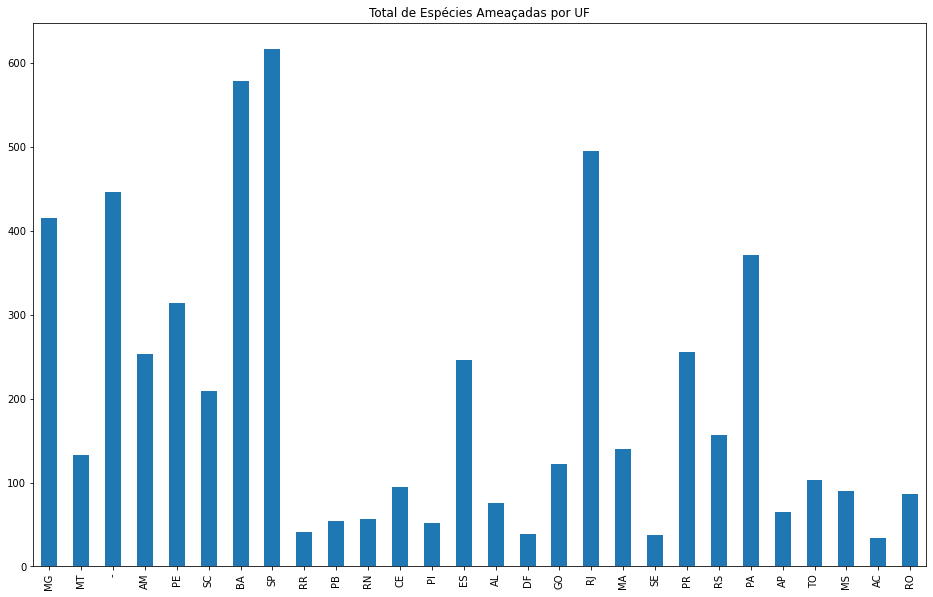

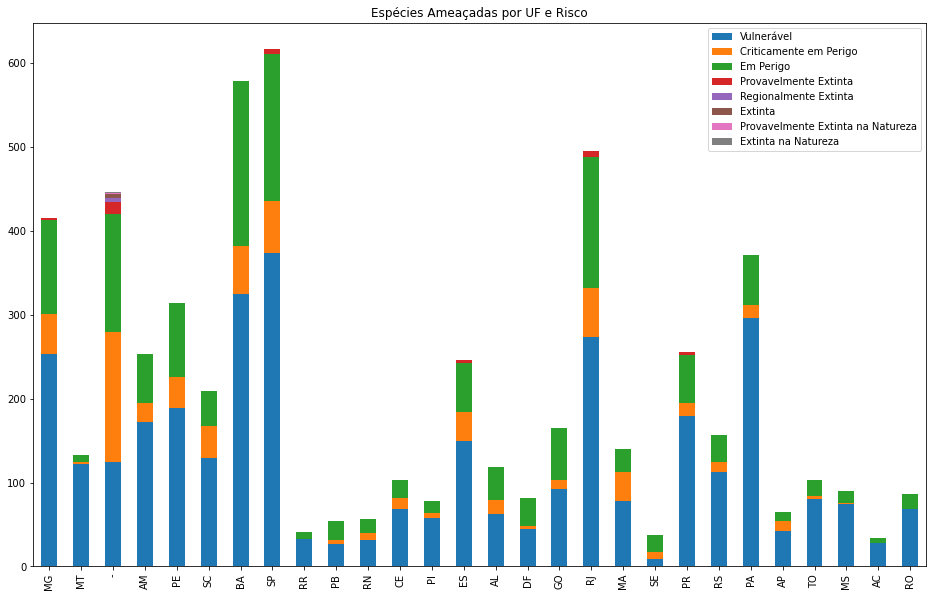

In [96]:
import matplotlib.pyplot as plt
totais_uf["Total"].plot(kind="bar", title="Total de Espécies Ameaçadas por UF", figsize=(16, 10))
totais_stack = totais_uf.drop(["Total"], axis = 1)
totais_stack.plot.bar(title="Espécies Ameaçadas por UF e Risco", stacked=True, figsize=(16, 10));

In [97]:
#totais_uf.plot(kind="bar", subplots=True, figsize=(18, 18))
#plt.delaxes

<a name="e5.2"></a>
### Dispersão entre Número de Espécies em Risco e IDH ou Alfabetização 

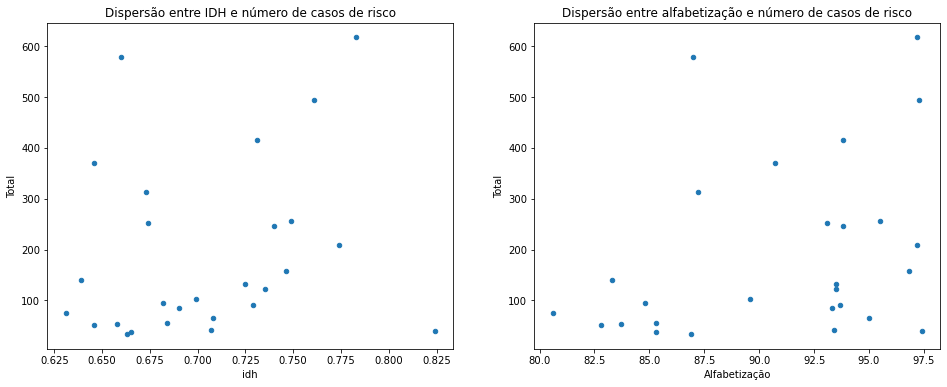

In [135]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,6)) #criando a grade 1x2 para organizar os gráficos
idh_uf.plot.scatter(ax = axes [0], x='idh', y='Total', title= "Dispersão entre IDH e número de casos de risco");
idh_uf.plot.scatter(ax = axes [1], x='Alfabetização', y='Total', title= "Dispersão entre alfabetização e número de casos de risco");
plt.show()

Vemos que evidentemente **não há nenhuma relação** entre os casos de risco e a alfabetização. Embora os pontos estejam levemente mais concentrados no gráfico de casos de risco por idh, também não podemos concluir que há uma relação linear entre estas duas variáveis. Contudo, para fins de aprendizado, vamos traçar a linha de regressão para a relação "Total" e "idh" utilizando a biblioteca seaborn

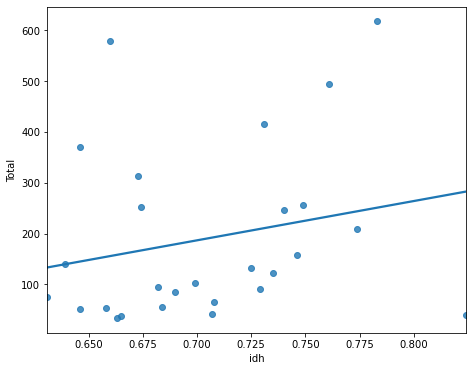

In [137]:
import seaborn as sb
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(7.5,6)) #criando a grade para definir o tamanho do gráfico
sb.regplot(ax = axes, x = "idh", y ="Total", ci = None, data=idh_uf)
plt.show()

<a name="e5.3"></a>
### Total de espécies ameaçadas por Divisão e Grau de Risco

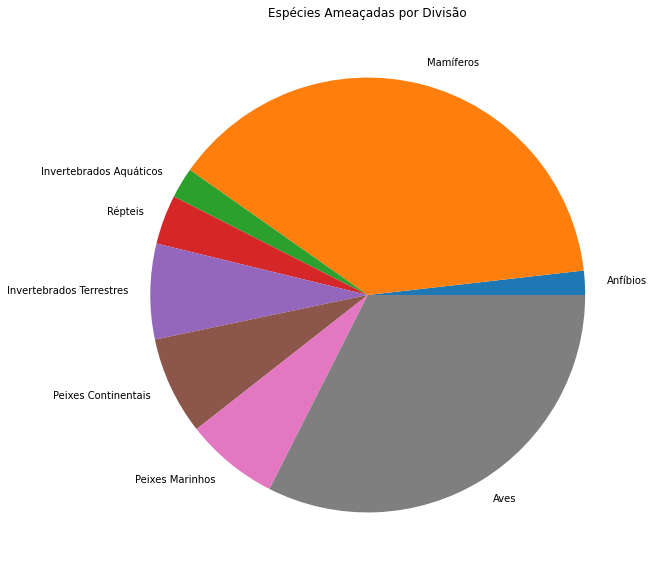

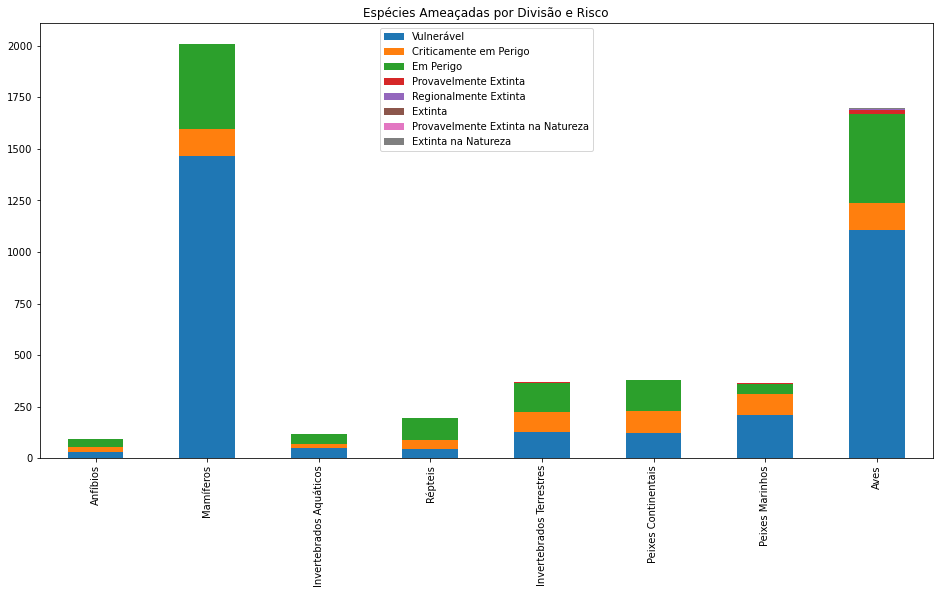

In [144]:
totais_divisao.plot.pie(y="Total", figsize = (10, 10), legend = False, title = "Espécies Ameaçadas por Divisão")
plt.axis('off')
divisao_stack = totais_divisao.drop(["Total"], axis = 1)
divisao_stack.plot.bar(title="Espécies Ameaçadas por Divisão e Risco", stacked=True, figsize=(16, 8));

<a name="biblio"></a>
## Bibliografia:

CNCFlora (2016). _Espécies Ameaçadas da Flora em UCs Federais_, versão 2016-10-03. Disponível em:http://ckan.jbrj.gov.br/dataset/ameacadas-em-ucs-federais. Acesso em 30/07/2021 (data de download)     
<br>
Instituto Chico Mendes de Conservação da Biodiversidade (2008). _Livro Vermelho da Fauna Brasileira Ameaçada de Extinção_, 
Vol.1. Disponível em: https://www.icmbio.gov.br/portal/images/stories/biodiversidade/fauna-brasileira/livro-vermelho/volumeI/vol_I_parte1.pdf. Acesso em 02/07/2021


#### Links Úteis:

[Pandas Intro Tutorials](https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/index.html)  
[10 Minutes to Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)        
[Pandas API Reference](https://pandas.pydata.org/pandas-docs/stable/reference/index.html)      
[Pandas Chart Visualization](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#visualization-barplot)    
[GeeksforGeeks](https://www.geeksforgeeks.org/)       
[Portal Brasileiro de Dados Abertos](https://dados.gov.br/)